In [1]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from ipynb.fs.full.preProcess import basic_preProcess, category_preProcess, color_preProcess, augment_contrast

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate

from collections import Counter

In [2]:
# For Local File:

# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

# train_dir = './train/'
# test_dir = './test/'
# train_df = pd.read_csv('./train.csv')

train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [3]:
train_data_color = []
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

train_shapes = []
test_shapes = []

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          h,w = img.shape[:2]
          train_shapes.append((h,w))
          img_ca = img.copy()
          img_co = img.copy()
          img_category = category_preProcess(img_ca)
          img_color = color_preProcess(img_co)

          img_color_output = basic_preProcess(img_color)
          img_category_output = basic_preProcess(img_category)
          # img_color = img
          # plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
          # plt.show()
          # break
          train_data_color.append(img_color_output)
          train_data_category.append(img_category_output)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")


for i in os.listdir(test_dir):
    if(i is not None):
      img_path = os.path.join(test_dir, i)
      img = cv.imread(img_path)
      if(img is not None):
        h,w = img.shape[:2]
        test_shapes.append((h,w))
        img = basic_preProcess(img)
        test_data.append(img)
        test_ids.append(i[:-4])
      else:
        print("no image found")


In [4]:
# augment
max_len = len(train_data_category)

for img_raw, warna in zip(train_data_color[:int(max_len*0.75)],train_warna[:int(max_len*0.75)]):
   if warna not in [3]:
      # print(warna)
      train_data_color.append(augment_contrast(img_raw))
      train_warna.append(warna)

In [5]:
xtrain_warna, xval_warna, ytrain_warna, yval_warna = train_test_split(
    train_data_color, train_warna,
    test_size=0.2, random_state=42,
    stratify=train_warna  # Ensures balanced class distribution for color labels
)

xtrain_jenis, xval_jenis, ytrain_jenis, yval_jenis = train_test_split(
    train_data_category, train_jenis,
    test_size=0.2, random_state=42,
    stratify=train_jenis  # Ensures balanced class distribution for category labels
)

In [6]:
print(len(train_df))
print("================")
print(train_df.describe())
print("================")
print(train_df.dtypes)
print("================")
print(train_df.isna().sum())
print("================")
print("duplicated : ",train_df.duplicated().sum())

777
               id       jenis       warna
count  777.000000  777.000000  777.000000
mean   389.000000    0.387387    2.202059
std    224.444871    0.487467    1.319597
min      1.000000    0.000000    0.000000
25%    195.000000    0.000000    1.000000
50%    389.000000    0.000000    2.000000
75%    583.000000    1.000000    3.000000
max    777.000000    1.000000    4.000000
id       int64
jenis    int64
warna    int64
dtype: object
id       0
jenis    0
warna    0
dtype: int64
duplicated :  0


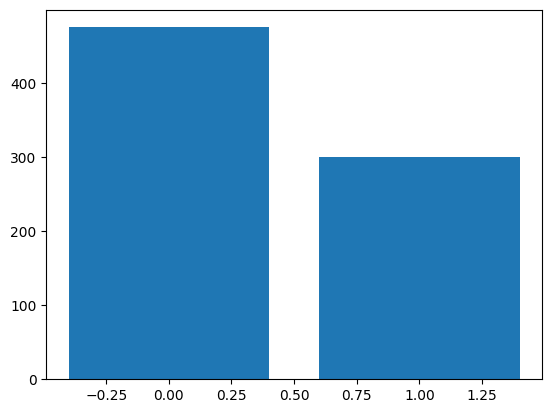

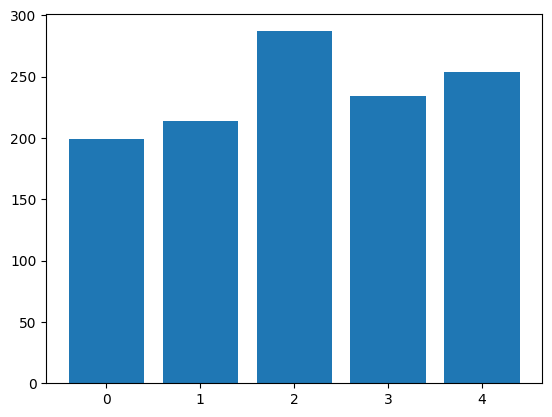

dict_keys([1, 0, 3, 2, 4]) dict_values([214, 199, 234, 287, 254])


In [7]:
# print(train_jenis)
jenis_counts = Counter(train_jenis) 
plt.bar(jenis_counts.keys(), jenis_counts.values())
plt.show()

warna_counts = Counter(train_warna)
plt.bar(warna_counts.keys(), warna_counts.values())
plt.show()
print(warna_counts.keys(), warna_counts.values())

In [8]:
print(train_shapes)
print(test_shapes)

[(200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (20

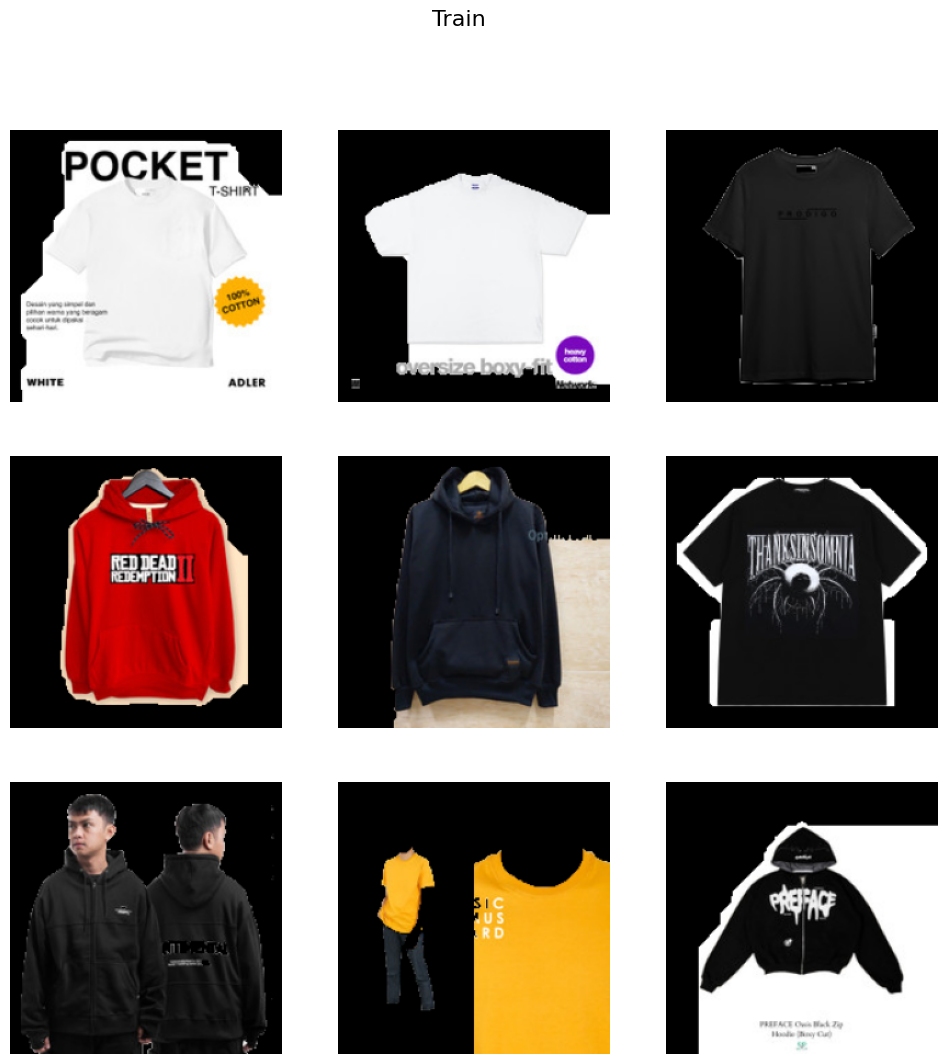

In [9]:
sample_images = np.random.choice(len(train_data_category), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img_show = train_data_category[curr]
    img_show = cv.cvtColor(img_show,cv.COLOR_BGR2RGB)

    plt.subplot(3, 3, idx)
    plt.imshow(img_show)
    plt.axis('off')
    # plt.title(os.path.basename(img_path))
plt.suptitle("Train", fontsize=16)
plt.show()

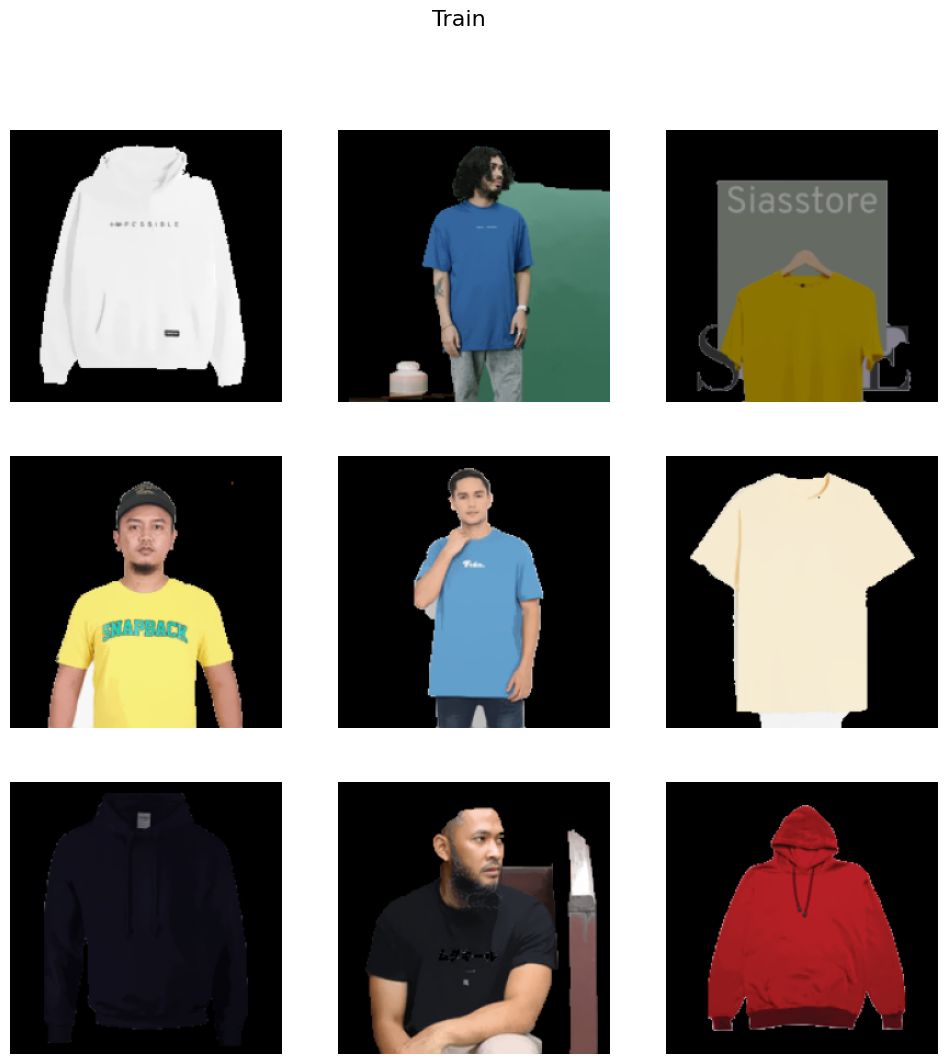

In [22]:
sample_images = np.random.choice(len(train_data_color), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img = train_data_color[curr]
    # img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    cv.imwrite("test.png",img)
    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(os.path.basename(img_path))
plt.suptitle("Train", fontsize=16)
plt.show()